# Machine Learning Individual Assignment - Heart Disease Classification

## Step 1 - Setup 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
df = pd.read_csv('heart-disease.csv')



## Step 2 - Data Cleaning and Preprocessing for EDA
Convert famhist into a binary variable (Present → 1, Absent → 0).

Check for outliers and missing values.

In [8]:
# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

#ensure binary var encoded correctly for use 
df['famhist'] = df['famhist'].map({'Present': 1, 'Absent': 0})



Missing values:
sbp          0
tobacco      0
ldl          0
adiposity    0
famhist      0
typea        0
obesity      0
alcohol      0
age          0
chd          0
dtype: int64


## Step 3 - Exploratory Data Analysis (EDA)

In this section, we perform our EDA, looking at 

1. Summary Statistics
2. Taget Variable Distribution
3. Correlation Matrix
4. Distribution of Feature Variables by CHD status 
5. Age Distribution by CHD
6. Family History Count by CHD 


Dataset shape: (462, 10)

First few rows:
   sbp  tobacco   ldl  adiposity  famhist  typea  obesity  alcohol  age  chd
0  160    12.00  5.73      23.11  Present     49    25.30    97.20   52    1
1  144     0.01  4.41      28.61   Absent     55    28.87     2.06   63    1
2  118     0.08  3.48      32.28  Present     52    29.14     3.81   46    0
3  170     7.50  6.41      38.03  Present     51    31.99    24.26   58    1
4  134    13.60  3.50      27.78  Present     60    25.99    57.34   49    1

Missing values:
sbp          0
tobacco      0
ldl          0
adiposity    0
famhist      0
typea        0
obesity      0
alcohol      0
age          0
chd          0
dtype: int64

Summary statistics:
              sbp     tobacco         ldl   adiposity       typea     obesity  \
count  462.000000  462.000000  462.000000  462.000000  462.000000  462.000000   
mean   138.326840    3.635649    4.740325   25.406732   53.103896   26.044113   
std     20.496317    4.593024    2.070909    7.78069

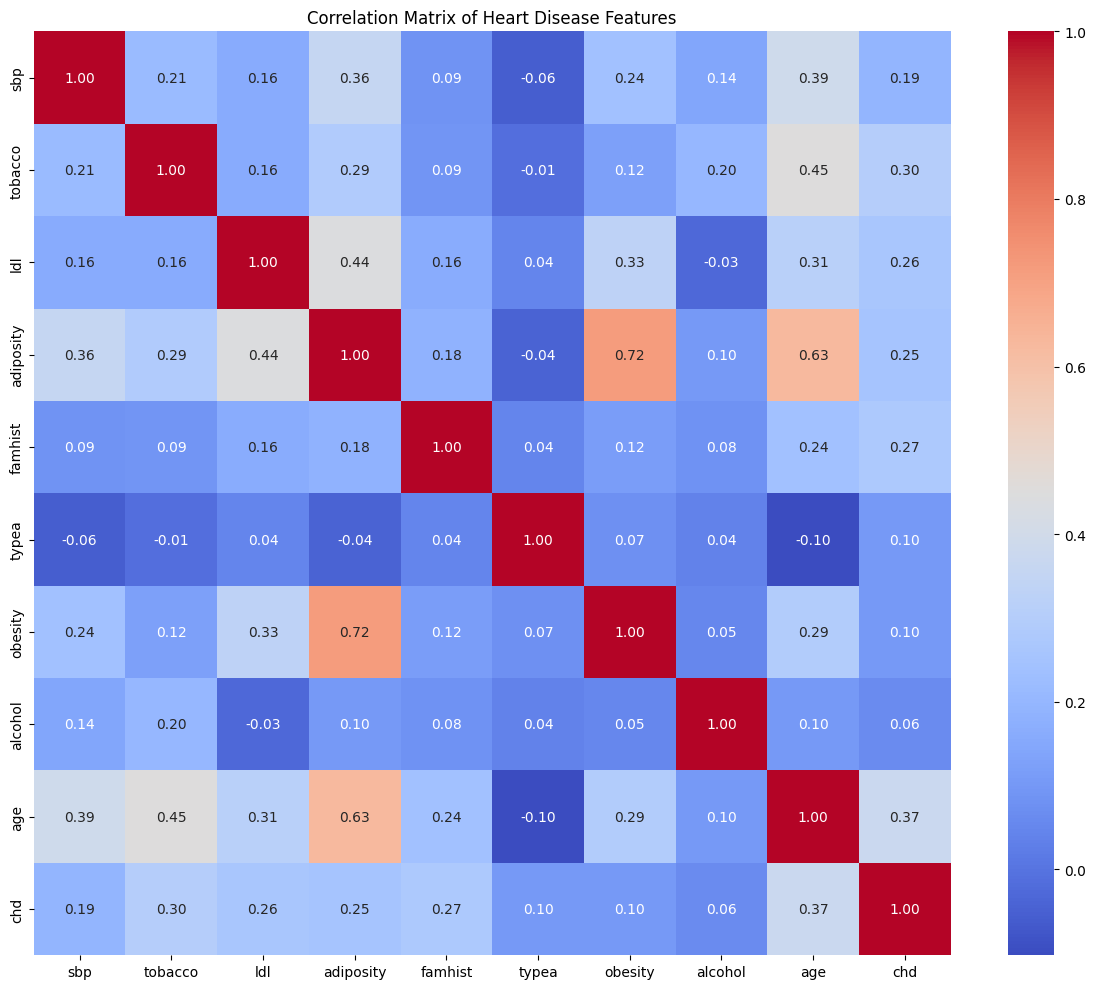

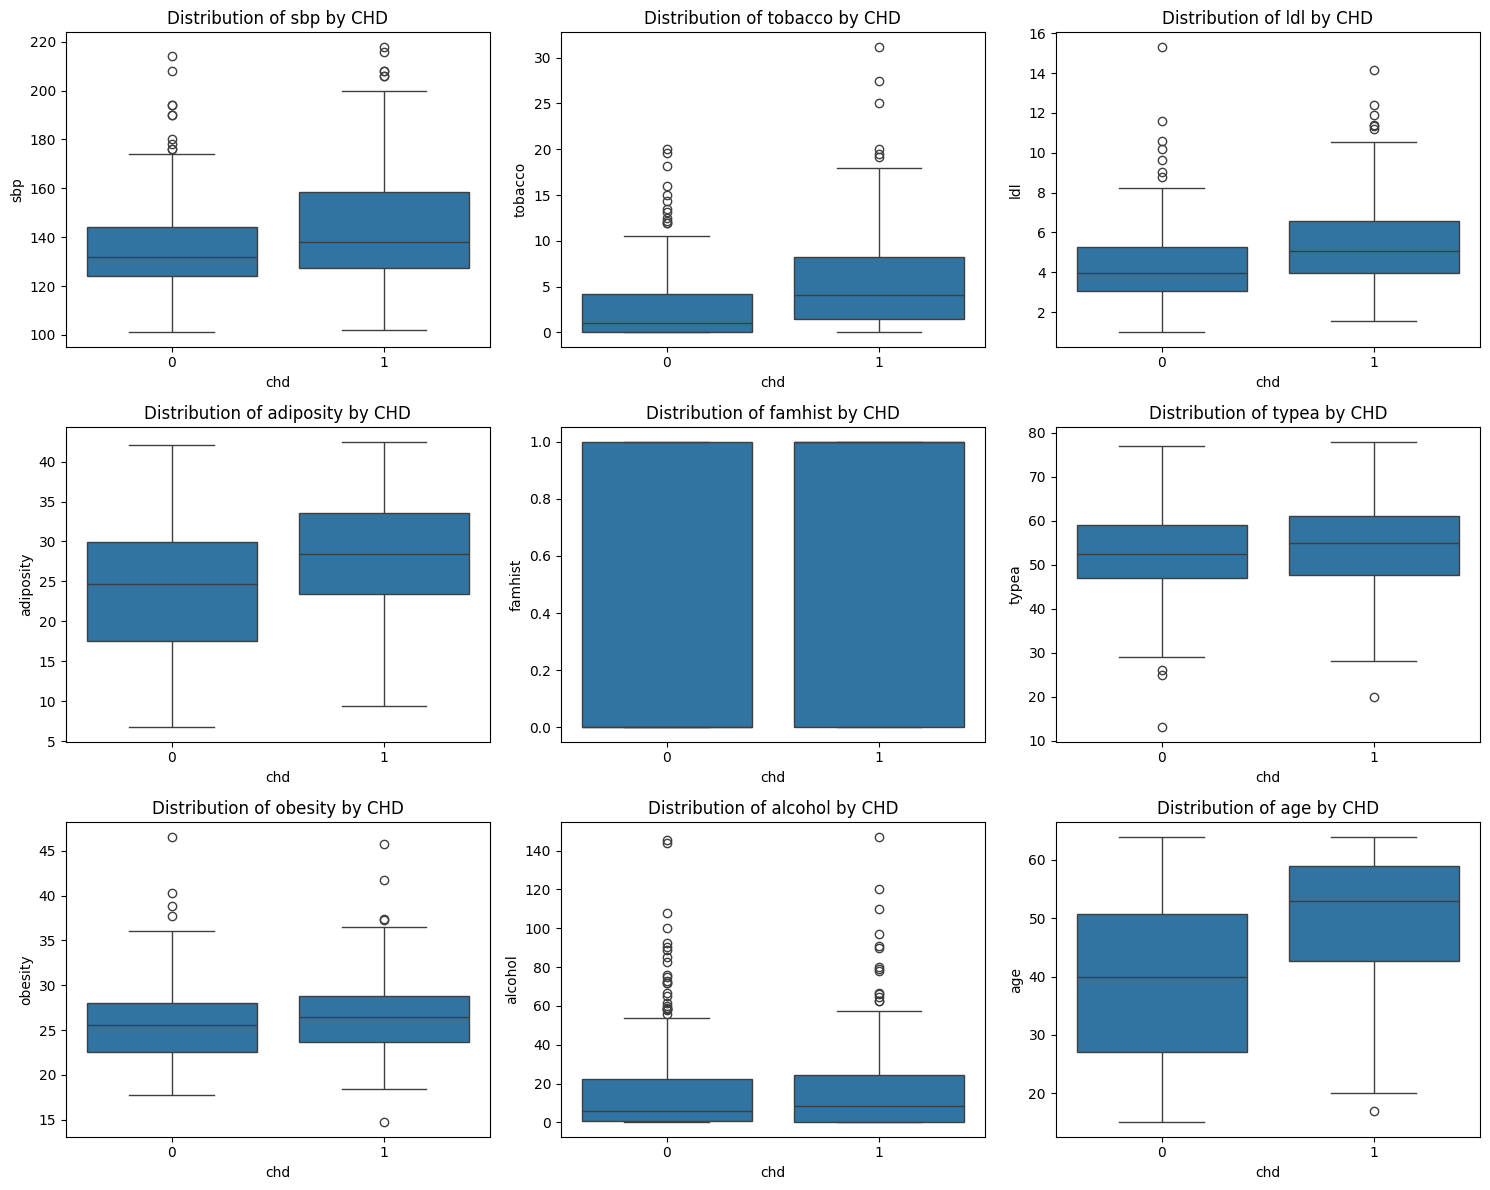

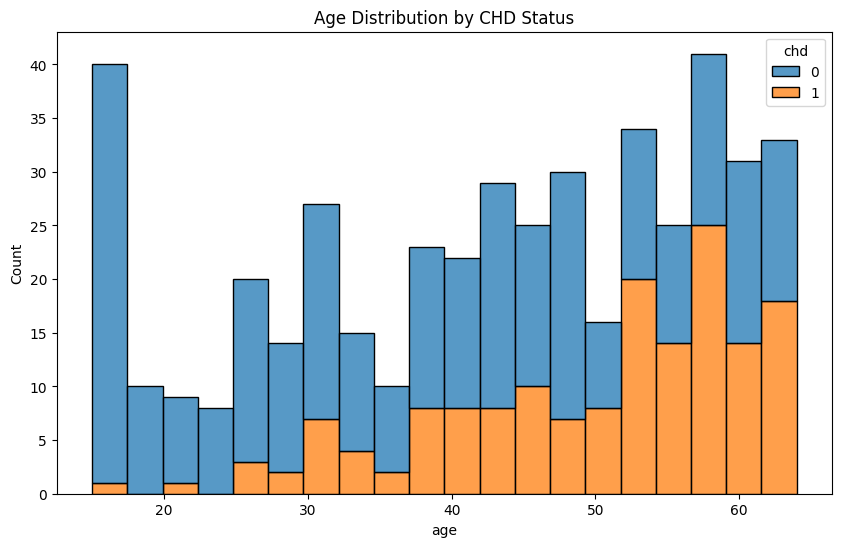

<Figure size 1000x600 with 0 Axes>

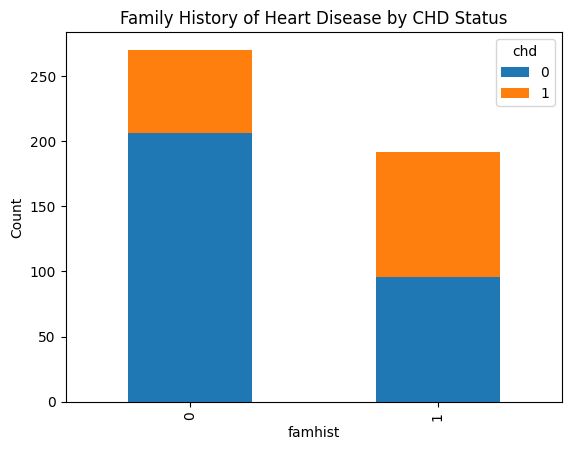

In [5]:
#Basic exploration
print(f"Dataset shape: {df.shape}")
print("\nFirst few rows:")
print(df.head())

#Data summary
print("\nSummary statistics:")
print(df.describe())

#Target variable distribution
print("\nTarget variable distribution:")
print(df['chd'].value_counts())
print(f"CHD rate: {df['chd'].mean()*100:.2f}%")

#Correlation matrix
plt.figure(figsize=(12, 10))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Heart Disease Features')
plt.tight_layout()
plt.savefig('correlation_matrix.png')

#Distribution of features by CHD status
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
features = df.columns[:-1]  # ll columns except the target
for i, feature in enumerate(features):
    row, col = i // 3, i % 3
    sns.boxplot(x='chd', y=feature, data=df, ax=axes[row, col])
    axes[row, col].set_title(f'Distribution of {feature} by CHD')
plt.tight_layout()
plt.savefig('feature_distributions.png')

#Age distribution by CHD
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='age', hue='chd', multiple='stack', bins=20)
plt.title('Age Distribution by CHD Status')
plt.savefig('age_distribution.png')

#Family history count by CHD
plt.figure(figsize=(10, 6))
famhist_chd = pd.crosstab(df['famhist'], df['chd'])
famhist_chd.plot(kind='bar', stacked=True)
plt.title('Family History of Heart Disease by CHD Status')
plt.ylabel('Count')
plt.savefig('famhist_chd.png')

## Step 4 - Pre-Processing for modelling 

Here we ensure the data is ready for us to model with, setting CHD as our Y variable and the features as our Xs, we use dummy variables to handle the categorical variable famhist.
Additionally we split our data into training and test sets (80-20 split) to use for our models and standardise our features (Xs) using the StandardScaler function

In [6]:
#Prepare data for modeling
X = df.drop('chd', axis=1)
y = df['chd']

#Handle categorical variable (famhist)
X = pd.get_dummies(X, drop_first=True)

#Split data into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#Standardise the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")
print(f"Features: {X.columns.tolist()}")

Training set shape: (369, 9)
Testing set shape: (93, 9)
Features: ['sbp', 'tobacco', 'ldl', 'adiposity', 'famhist', 'typea', 'obesity', 'alcohol', 'age']


## Step 5 - Logistic Regression with Ridge Penalty 
We start by building a basic logistic regression using the L2 (ridge) penalty as required, before fine tuning the parameters to increase model accuracy 

Basic Ridge Logistic Regression Test Accuracy: 0.7419

Classification Report for Basic Ridge Logistic Regression:
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        61
           1       0.62      0.62      0.62        32

    accuracy                           0.74        93
   macro avg       0.71      0.71      0.71        93
weighted avg       0.74      0.74      0.74        93


Feature Coefficients (Basic Model):
     Feature  Coefficient
8        age     0.710994
4    famhist     0.435246
2        ldl     0.393857
5      typea     0.360810
1    tobacco     0.316446
0        sbp     0.141095
6    obesity    -0.011869
7    alcohol    -0.046623
3  adiposity    -0.114193


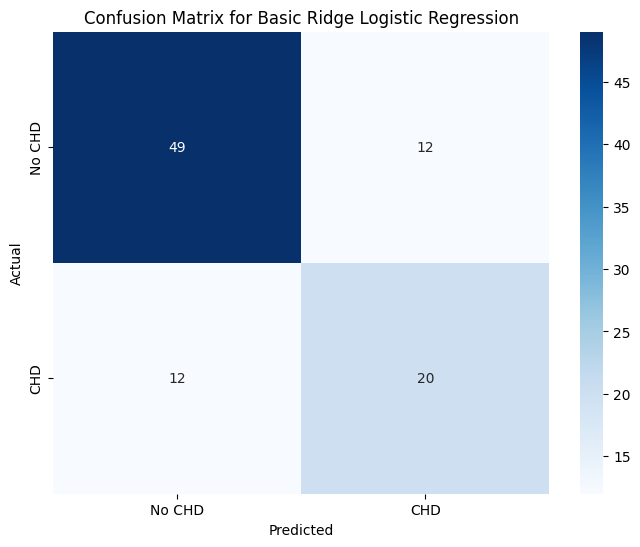

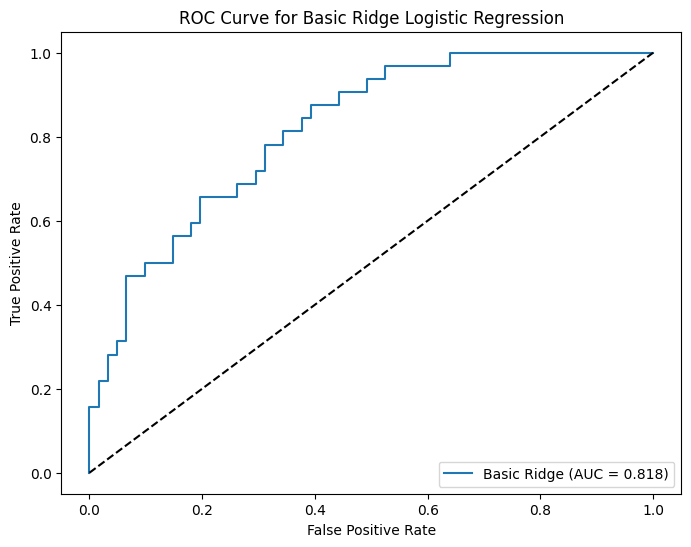

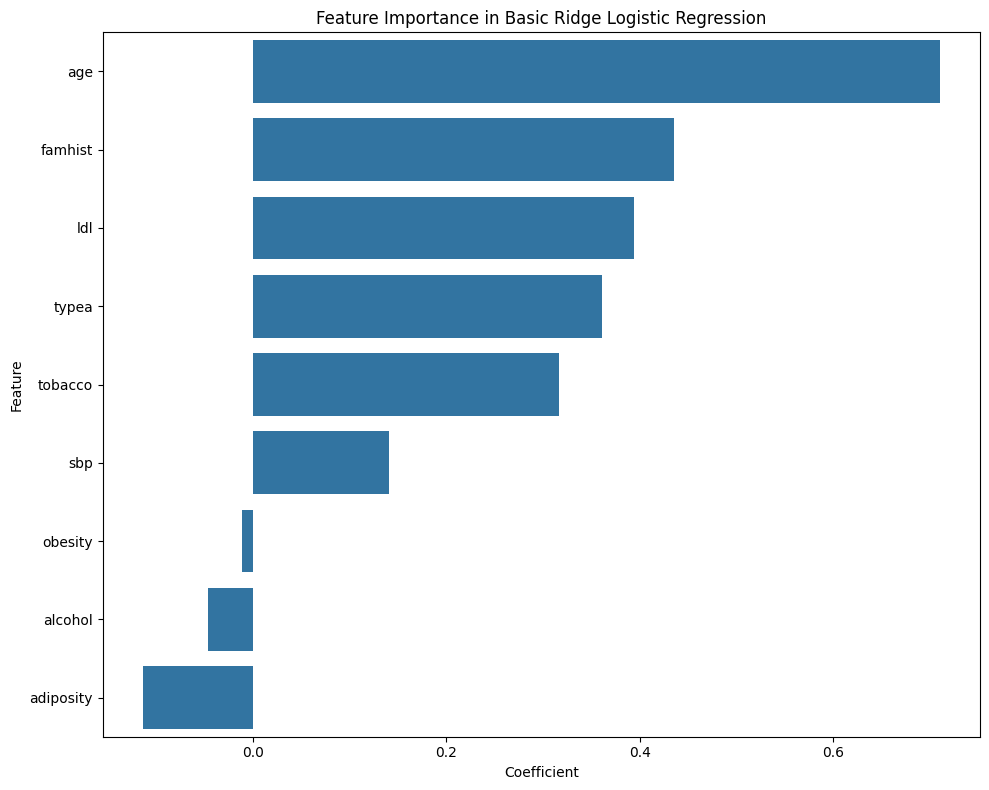

In [9]:
#Basic logistic regression with ridge penalty (L2 regularisation)
#Use a simple default value for C (regularization strength)
basic_ridge_model = LogisticRegression(penalty='l2', C=1.0, solver='liblinear', random_state=42)
basic_ridge_model.fit(X_train_scaled, y_train)

#Evaluate on test set
y_pred_basic = basic_ridge_model.predict(X_test_scaled)
basic_accuracy = accuracy_score(y_test, y_pred_basic)
print(f"Basic Ridge Logistic Regression Test Accuracy: {basic_accuracy:.4f}")

#Classification report 
basic_report = classification_report(y_test, y_pred_basic)
print("\nClassification Report for Basic Ridge Logistic Regression:")
print(basic_report)

#Confusion matrix 
cm_basic = confusion_matrix(y_test, y_pred_basic)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_basic, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No CHD', 'CHD'], 
            yticklabels=['No CHD', 'CHD'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Basic Ridge Logistic Regression')
plt.savefig('basic_ridge_confusion_matrix.png')

#ROC curve 
y_pred_proba_basic = basic_ridge_model.predict_proba(X_test_scaled)[:, 1]
fpr_basic, tpr_basic, _ = roc_curve(y_test, y_pred_proba_basic)
roc_auc_basic = auc(fpr_basic, tpr_basic)

plt.figure(figsize=(8, 6))
plt.plot(fpr_basic, tpr_basic, label=f'Basic Ridge (AUC = {roc_auc_basic:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Basic Ridge Logistic Regression')
plt.legend(loc='lower right')
plt.savefig('basic_ridge_roc_curve.png')

# eature importance (coefficients)
coef_df_basic = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': basic_ridge_model.coef_[0]
})
coef_df_basic = coef_df_basic.sort_values('Coefficient', ascending=False)
print("\nFeature Coefficients (Basic Model):")
print(coef_df_basic)

#Plot feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x='Coefficient', y='Feature', data=coef_df_basic)
plt.title('Feature Importance in Basic Ridge Logistic Regression')
plt.tight_layout()
plt.savefig('basic_ridge_coefficients.png')


Best regularisation strength (C): 0.03359818286283781
Tuned Ridge Logistic Regression Test Accuracy: 0.7419
Improvement over basic model: 0.00%

Classification Report for Tuned Ridge Logistic Regression:
              precision    recall  f1-score   support

           0       0.82      0.77      0.80        61
           1       0.61      0.69      0.65        32

    accuracy                           0.74        93
   macro avg       0.72      0.73      0.72        93
weighted avg       0.75      0.74      0.75        93


Feature Coefficients (Tuned Model):
     Feature  Coefficient
8        age     0.392111
4    famhist     0.313845
2        ldl     0.268002
1    tobacco     0.245675
5      typea     0.210631
0        sbp     0.114765
3  adiposity     0.055539
7    alcohol    -0.021822
6    obesity    -0.030411

Coefficient Changes After Tuning:
     Feature  Basic Model  Tuned Model  Difference
8        age     0.710994     0.392111   -0.318882
3  adiposity    -0.114193     0.05

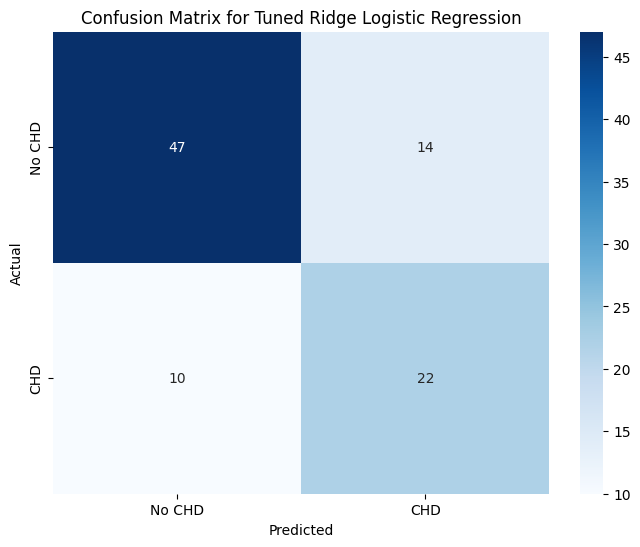

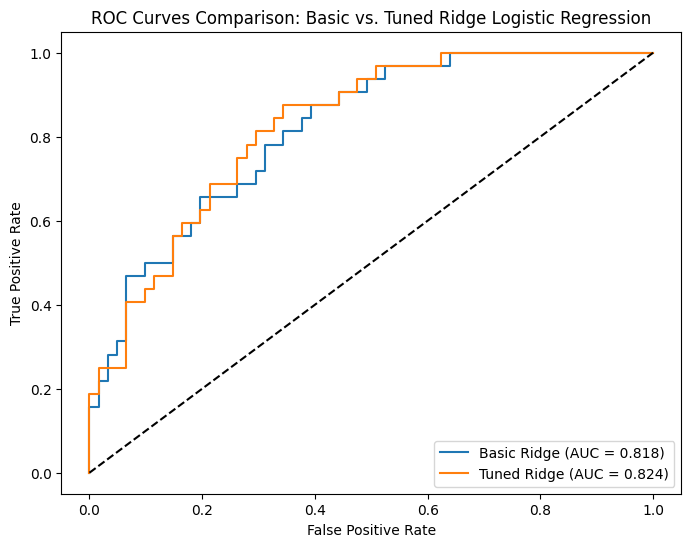

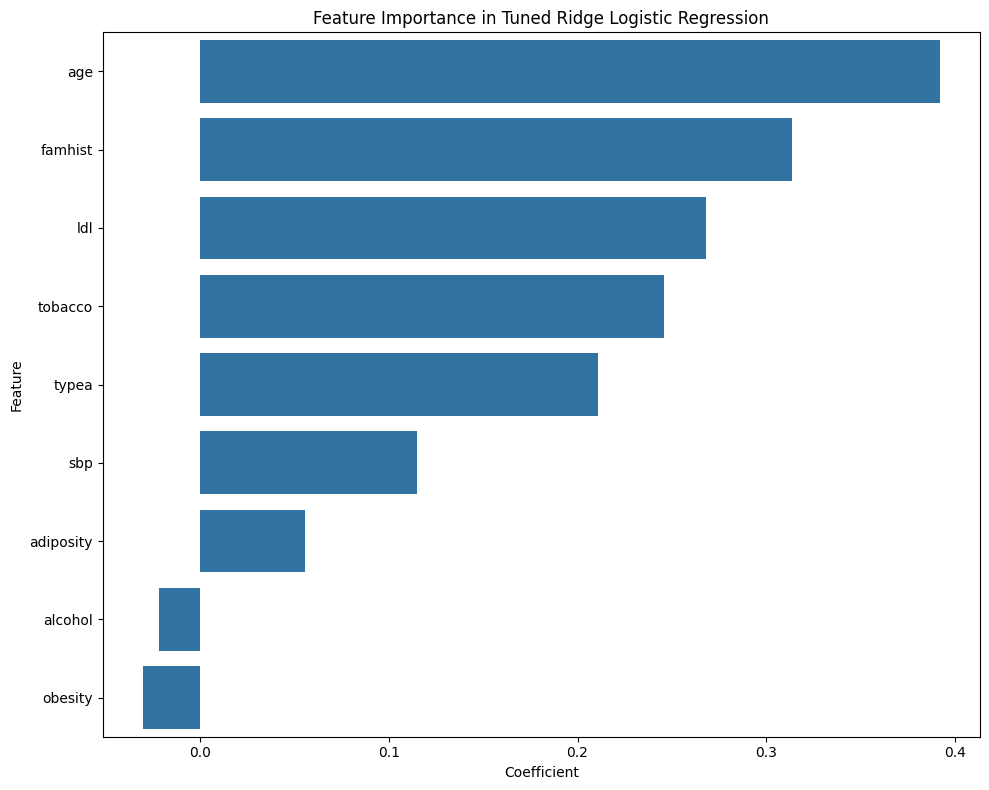

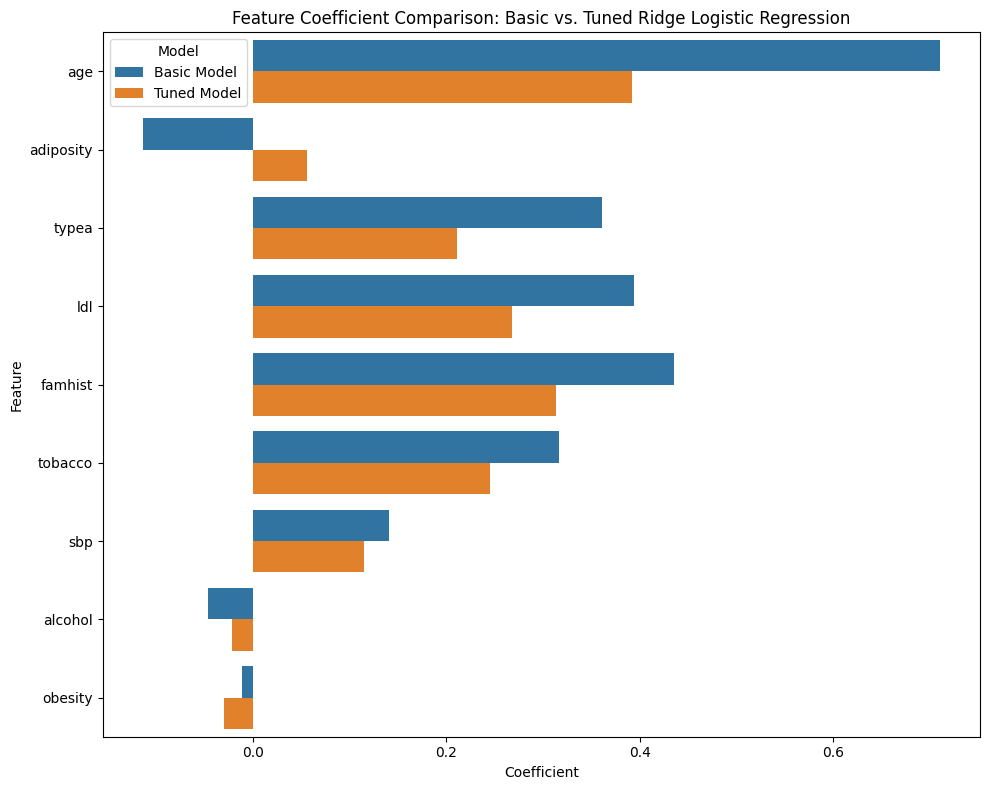

In [10]:
#Fine-tune logistic regression with ridge penalty
#Use grid search to find the optimal regularisation strength
param_grid = {'C': np.logspace(-4, 4, 20)}  #Test a range of C values on logarithmic scale
ridge_log_reg = LogisticRegression(penalty='l2', solver='liblinear', random_state=42, max_iter=1000)
grid_search = GridSearchCV(ridge_log_reg, param_grid, cv=5, scoring='accuracy') #five-fold cross validation 
grid_search.fit(X_train_scaled, y_train)

#Get best model
best_ridge_model = grid_search.best_estimator_
best_C = grid_search.best_params_['C']
print(f"\nBest regularisation strength (C): {best_C}")

#Evaluate on test set
y_pred_tuned = best_ridge_model.predict(X_test_scaled)
tuned_accuracy = accuracy_score(y_test, y_pred_tuned)
print(f"Tuned Ridge Logistic Regression Test Accuracy: {tuned_accuracy:.4f}")
print(f"Improvement over basic model: {(tuned_accuracy - basic_accuracy) * 100:.2f}%")

#Classification report for tuned model
tuned_report = classification_report(y_test, y_pred_tuned)
print("\nClassification Report for Tuned Ridge Logistic Regression:")
print(tuned_report)

#Confusion matrix for tuned model
cm_tuned = confusion_matrix(y_test, y_pred_tuned)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No CHD', 'CHD'], 
            yticklabels=['No CHD', 'CHD'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Tuned Ridge Logistic Regression')
plt.savefig('tuned_ridge_confusion_matrix.png')

#ROC curve for tuned model
y_pred_proba_tuned = best_ridge_model.predict_proba(X_test_scaled)[:, 1]
fpr_tuned, tpr_tuned, _ = roc_curve(y_test, y_pred_proba_tuned)
roc_auc_tuned = auc(fpr_tuned, tpr_tuned)

#Compare ROC curves for basic and tuned models
plt.figure(figsize=(8, 6))
plt.plot(fpr_basic, tpr_basic, label=f'Basic Ridge (AUC = {roc_auc_basic:.3f})')
plt.plot(fpr_tuned, tpr_tuned, label=f'Tuned Ridge (AUC = {roc_auc_tuned:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison: Basic vs. Tuned Ridge Logistic Regression')
plt.legend(loc='lower right')
plt.savefig('ridge_roc_comparison.png')

#Feature importance (coefficients) for tuned model
coef_df_tuned = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': best_ridge_model.coef_[0]
})
coef_df_tuned = coef_df_tuned.sort_values('Coefficient', ascending=False)
print("\nFeature Coefficients (Tuned Model):")
print(coef_df_tuned)

#Plot feature importance for tuned model
plt.figure(figsize=(10, 8))
sns.barplot(x='Coefficient', y='Feature', data=coef_df_tuned)
plt.title('Feature Importance in Tuned Ridge Logistic Regression')
plt.tight_layout()
plt.savefig('tuned_ridge_coefficients.png')

#Compare coefficients between basic and tuned models
coef_comparison = pd.DataFrame({
    'Feature': X.columns,
    'Basic Model': basic_ridge_model.coef_[0],
    'Tuned Model': best_ridge_model.coef_[0]
})
coef_comparison['Difference'] = coef_comparison['Tuned Model'] - coef_comparison['Basic Model']
coef_comparison = coef_comparison.sort_values('Difference', key=abs, ascending=False)
print("\nCoefficient Changes After Tuning:")
print(coef_comparison)

#Visualise the coefficient differences
plt.figure(figsize=(10, 8))
coef_comparison_melted = pd.melt(coef_comparison, id_vars=['Feature'], 
                                 value_vars=['Basic Model', 'Tuned Model'],
                                 var_name='Model', value_name='Coefficient')
sns.barplot(x='Coefficient', y='Feature', hue='Model', data=coef_comparison_melted)
plt.title('Feature Coefficient Comparison: Basic vs. Tuned Ridge Logistic Regression')
plt.tight_layout()
plt.savefig('ridge_coefficient_comparison.png')

## Step 6 - Other Classifiers 
Look at other models to see if we can get a better accuracy score, we will look at the following classifiers:

1. Random Forest
2. Gradient Boosting
3. Support Vector Machine (SVM)
4. K Nearest Neighbours (KNN)

In [11]:
#Setup classifiers
classifiers = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'KNN': KNeighborsClassifier()
}

#Evaluate each classifier with cross-validation
print("\nBasic Classifier Performance (5-fold CV):")
for name, clf in classifiers.items():
    cv_scores = cross_val_score(clf, X_train_scaled, y_train, cv=5, scoring='accuracy')
    print(f"{name}: Mean accuracy = {cv_scores.mean():.4f}, Std = {cv_scores.std():.4f}")


Basic Classifier Performance (5-fold CV):
Random Forest: Mean accuracy = 0.6829, Std = 0.0542
Gradient Boosting: Mean accuracy = 0.6748, Std = 0.0601
SVM: Mean accuracy = 0.7156, Std = 0.0373
KNN: Mean accuracy = 0.6750, Std = 0.0481



Tuning Random Forest...
Best parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation accuracy: 0.7099
Test accuracy: 0.6989

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.77      0.77      0.77        61
           1       0.56      0.56      0.56        32

    accuracy                           0.70        93
   macro avg       0.67      0.67      0.67        93
weighted avg       0.70      0.70      0.70        93


Tuning Gradient Boosting...
Best parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}
Best cross-validation accuracy: 0.7235
Test accuracy: 0.6989

Classification Report for Gradient Boosting:
              precision    recall  f1-score   support

           0       0.77      0.77      0.77        61
           1       0.56      0.56      0.56        32

    accuracy                           0.70 

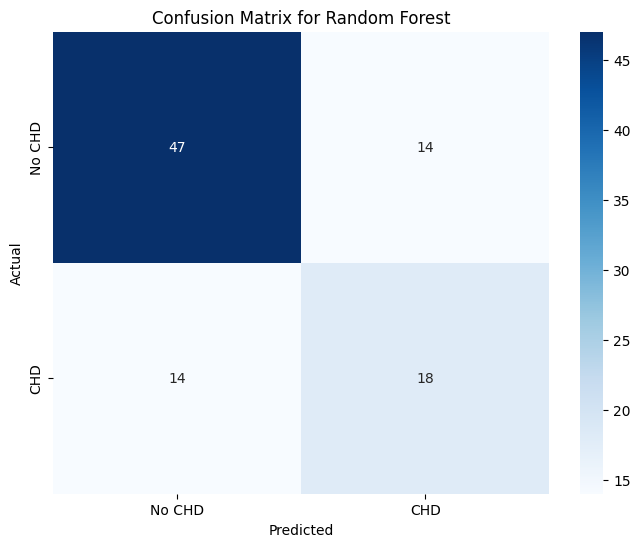

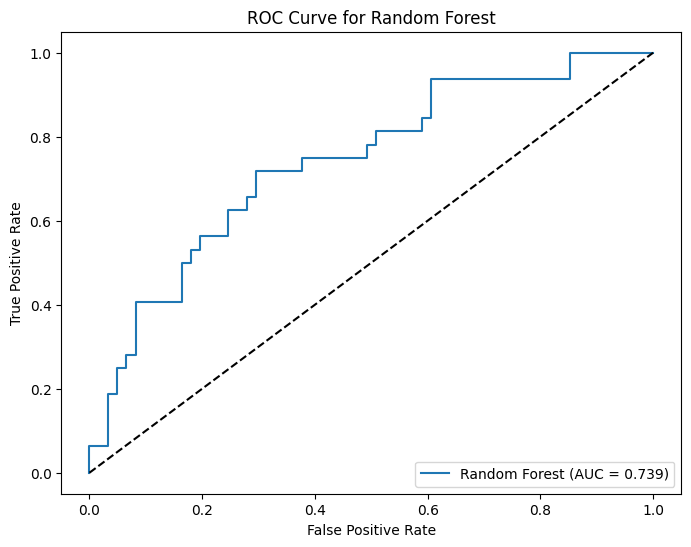

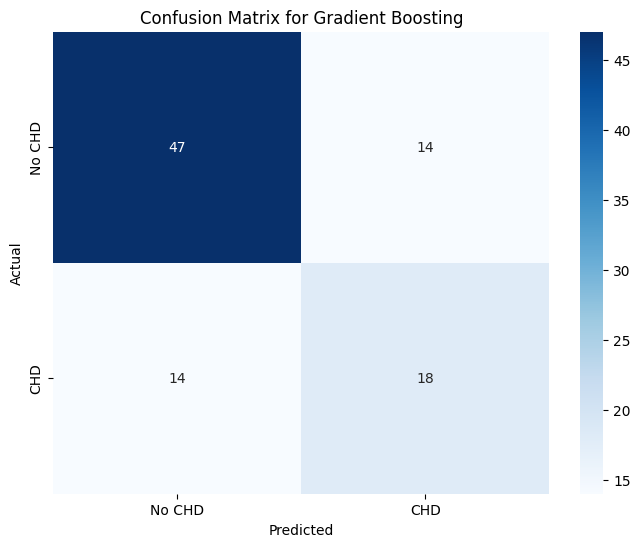

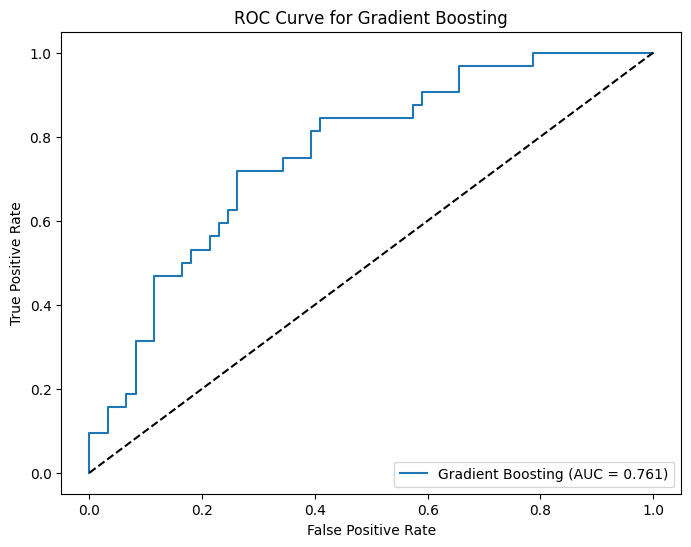

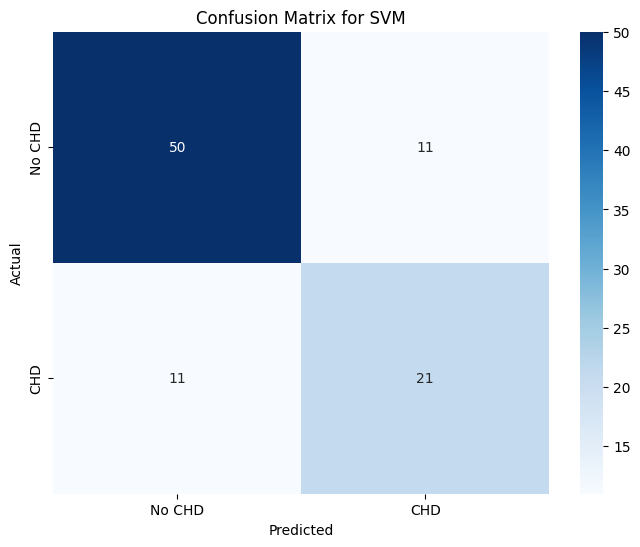

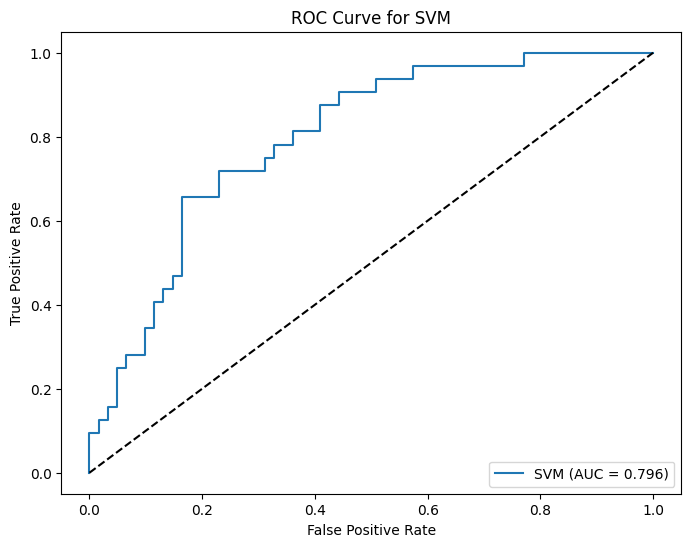

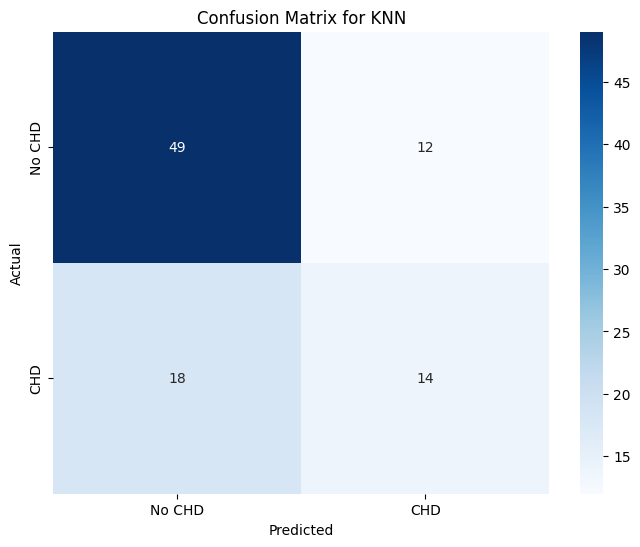

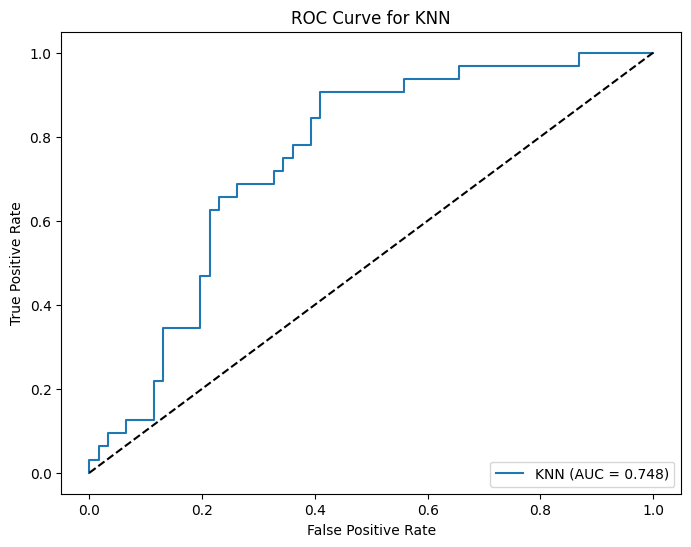

In [12]:
#Hyperparameter grids for each classifier
param_grids = {
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'Gradient Boosting': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 1.0]
    },
    'SVM': {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.1, 0.01],
        'kernel': ['rbf', 'linear']
    },
    'KNN': {
        'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    }
}

#Fine-tune each classifier
best_models = {}
best_accuracies = {}

for name, clf in classifiers.items():
    print(f"\nTuning {name}...")
    grid_search = GridSearchCV(clf, param_grids[name], cv=5, scoring='accuracy')
    grid_search.fit(X_train_scaled, y_train)
    
    best_models[name] = grid_search.best_estimator_
    best_params = grid_search.best_params_
    best_accuracies[name] = grid_search.best_score_
    
    print(f"Best parameters: {best_params}")
    print(f"Best cross-validation accuracy: {best_accuracies[name]:.4f}")
    
    #Evaluate on test set
    y_pred = best_models[name].predict(X_test_scaled)
    test_accuracy = accuracy_score(y_test, y_pred)
    print(f"Test accuracy: {test_accuracy:.4f}")
    
    #Classification report
    print(f"\nClassification Report for {name}:")
    print(classification_report(y_test, y_pred))
    
    #Confusion matrices
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No CHD', 'CHD'],
                yticklabels=['No CHD', 'CHD'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {name}')
    plt.savefig(f'{name.replace(" ", "_").lower()}_confusion_matrix.png')
    
    #ROC curves
    y_pred_proba = best_models[name].predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {name}')
    plt.legend(loc='lower right')
    plt.savefig(f'{name.replace(" ", "_").lower()}_roc_curve.png')

## Step 7 - Model Comparison 
Lets plot the ROC curves of all models to see that whcih best performs by this metric 


Model Comparison:
Random Forest: Test Accuracy = 0.7099
Gradient Boosting: Test Accuracy = 0.7235
SVM: Test Accuracy = 0.7291
KNN: Test Accuracy = 0.7211
Ridge Logistic Regression: Test Accuracy = 0.7419

Best model: Ridge Logistic Regression with accuracy 0.7419


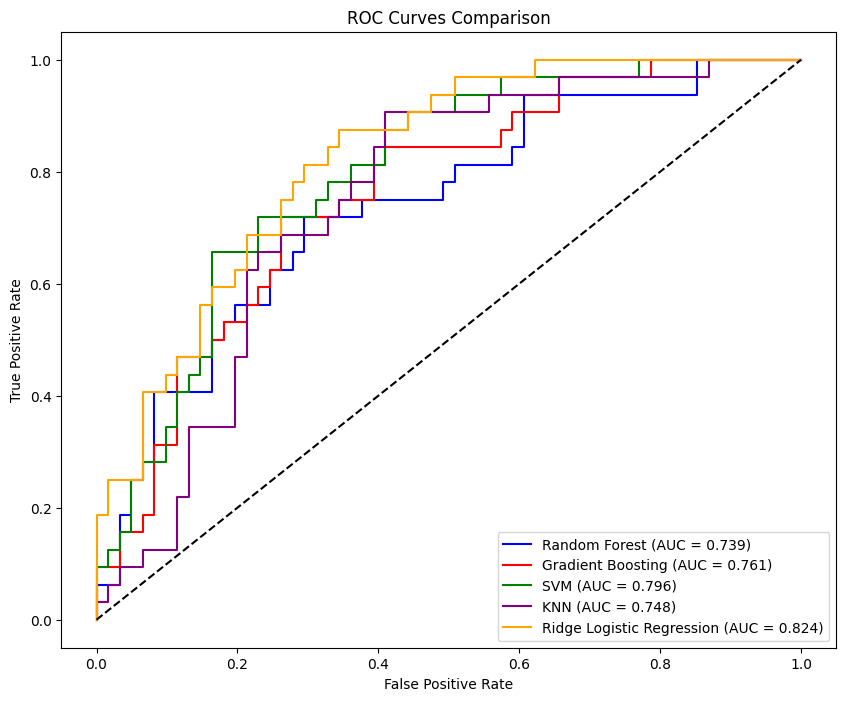

In [21]:
#Compare all models accuracy
all_accuracies = {**best_accuracies, 'Ridge Logistic Regression': ridge_accuracy}
best_model_name = max(all_accuracies, key=all_accuracies.get)
best_model = best_models.get(best_model_name, best_ridge_model)

print("\nModel Comparison:")
for name, accuracy in all_accuracies.items():
    print(f"{name}: Test Accuracy = {accuracy:.4f}")
print(f"\nBest model: {best_model_name} with accuracy {all_accuracies[best_model_name]:.4f}")

#ROC curves comparison
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'purple', 'orange']
models = {**best_models, 'Ridge Logistic Regression': best_ridge_model}

for i, (name, model) in enumerate(models.items()):
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i], label=f'{name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend(loc='lower right')
plt.savefig('roc_comparison.png')